In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
import lib.cmaes
import lib.riversi

import importlib
importlib.reload(lib.cmaes)
importlib.reload(lib.riversi)

from lib.cmaes import CMAES
from lib.riversi import RiversiBoard, GameEnv, RandomEnemy

In [7]:
from copy import deepcopy


def evaluate(x:np.ndarray):
    score = 0
    for i in range(100):
        if i%2:
            color = RiversiBoard.BLACK
        else:
            color = RiversiBoard.WHITE
        
        
        game = GameEnv(RandomEnemy(RiversiBoard.turn_color(color=color)), color)
        
        while True:
            mb, yb, fin = game.get_env()
            if fin: break
            now = RiversiBoard(mb, yb)
            
            max_e = -float("inf")
            best_p = (-1, -1)
            for p in now.get_places_to_put(RiversiBoard.BLACK):
                new_bd = RiversiBoard(mb, yb)
                new_bd.put(RiversiBoard.BLACK, p)
                env_vec = np.zeros(128, np.int32)
                env_vec[:64] = new_bd[RiversiBoard.BLACK].to_ndarray().flatten()
                env_vec[64:] = new_bd[RiversiBoard.WHITE].to_ndarray().flatten()
                e = np.dot(env_vec, x)
                if e > max_e:
                    best_p = p
                    max_e = e
            
            game.put(best_p)
        
        score += game.score()
    
    return -score/100
        
            

In [8]:
es = CMAES(func=evaluate,\
            init_mean=np.zeros(128),\
            init_sigma=10,\
            nsample=10)

mean = np.zeros(500, dtype=np.float64)

for i in range(500):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    if np.all(es.sigma*np.sqrt(es.D) < 1e-10):
        break

print(es.mean)

[ 268.92768139   26.26407246   31.77580065   88.17868093  164.39896441
   91.34596702   64.86840203  181.1147931     3.46997667 -230.33786711
   28.7842907  -180.43307679   55.85176328  114.10893038   87.6754242
   78.12123275  -44.39785472  -20.82436045   70.14510524  123.02411493
  102.22337311  228.70468891  114.62661501   45.13108373   44.79520061
  294.00882275  -22.32708573   78.79113947 -297.09110668  188.50675418
 -204.45760666  111.19636422  124.17804957   66.75950344  -13.21272993
  187.10123711 -165.55457236 -199.55299911   38.79858937  -40.92831817
   32.89156199 -106.86420988   96.41783579 -148.20069006  -84.47387719
 -122.21018819  -68.96321954  -45.17421204  135.43691664 -155.49444774
  339.34458073   32.91641773 -162.02769111 -178.75897972  -12.17396421
  -45.13113457  488.90861691 -393.71498478   -7.92587573   98.01514511
    2.25466289   74.95698509   36.87865406   36.25293306 -105.20515256
 -153.42452794  -79.87175877  -95.5814908    25.7946805   101.99080409
   99.6

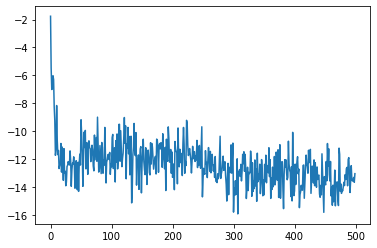

In [9]:
# plt.semilogy(mean)
plt.plot(mean)

In [10]:
df = pd.DataFrame([es.mean])
df.to_csv("./model/learn_data.csv")